# Modèle V4 de voiture autonome sur DonkeyCarSimulator

Cette version se veut la plus généraliste possible. Ce notebook fonctionne aussi bien sur Jupyter que sur Google Colab

In [3]:
import os
# Choisir le GPU:1
# Pour du calcul sur CPU, mettre -1
# Si ça fonctionne... :/
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm
import json
from PIL import Image
import base64
from io import BytesIO
import inspect
from matplotlib import pyplot as plt
import datetime

### Configuration GPU
Avoir la liste des GPU et choisir sur quel GPU lancer l'entraînement

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print(get_available_gpus())

['/device:GPU:0']


In [5]:
print(tf.test.gpu_device_name())

/device:GPU:0


Si `CUDA_VISIBLE_DEVICES` ne permet pas de lancer l'entraînement sur le GPU précisé,
on peut tout à fait encadrer le fit avec ce code :
```
with tf.device("/gpu:1"):
    model.fit(...)
```

## Importer la dataset

### Google Drive

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!rm -Rf "corentin_renault_20000_record_controller"
!cp "drive/My Drive/ColabStorage/DonkeyCar/Simulator/Dataset/corentin_renault_20000_record_controller.eslr" "dataset.eslr"

### Autre source (CURL)

In [ ]:
!curl <LIEN_URL> --output dataset.eslr

## Configuration

In [6]:
TIME = str(time())

### ENVIRONEMENT ###
STORAGE_ROOT_DIR = "data"

### INPUT ###
IMAGE_SHAPE = (120,160, 3)

### MODEL ###
MODEL_NAME = "DCDeepModelV4.0-reda-renault-speed_accel_gyro-" + TIME
os.environ["MODEL_NAME"] = MODEL_NAME
os.environ["MODEL_NAME_TAR"] = MODEL_NAME+".tar.gz"

SAVE_PATH = os.path.join(STORAGE_ROOT_DIR, "model", MODEL_NAME)
os.environ["SAVE_PATH"] = SAVE_PATH
os.makedirs(SAVE_PATH, exist_ok=True)

CHECKPOINT_PATH = os.path.join(SAVE_PATH, "checkpoints")
# don't remove the last "s" in "checkpoints"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
CHECKPOINT_FILEPATH = os.path.join(CHECKPOINT_PATH, "checkpoint-{epoch:02d}.weight")

ROOT_TENSORLOG_PATH = os.path.join(STORAGE_ROOT_DIR, "log", MODEL_NAME)
os.makedirs(ROOT_TENSORLOG_PATH, exist_ok=True)

def get_new_tensorlog_path():
    special_log_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    special_log_path = os.path.join(ROOT_TENSORLOG_PATH, special_log_name)
    os.makedirs(special_log_path)
    os.environ["LOG_PATH"] = special_log_path
    return special_log_path

BATCH_SIZE = 256

### DATASET ###
DATASET_NAME = "corentin_renault_30000_clean_record_controller"
DATASET_FILE_PATH = os.path.join(STORAGE_ROOT_DIR, "sample", DATASET_NAME + ".eslr")

IMAGE_PATH = "images"
DATASET_LABEL_FILENAME = "label.csv"

DATASET_LABEL_PATH = os.path.join(DATASET_NAME, DATASET_LABEL_FILENAME)
DATASET_IMAGE_PATH = os.path.join(DATASET_NAME, IMAGE_PATH)

SPLIT_VALIDATION = 0.05
SPLIT_TEST = 0.05

print(MODEL_NAME)
print("Ok.")

DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247
Ok.


## Extraire la dataset

On convertit chaque ligne du fichier *.eslr envoyées par le serveur en :
- une image qui sera stockée dans le dossier `<DATASET_NAME>/<DATASET_IMAGE_PATH>`
- une ligne dans le csv label.csv avec toutes les infos (reliées à aux images par leur `path`)

In [7]:
class ESLRExtractor:
  def __init__(self, eslr_path):
    self.eslr_path = eslr_path
    if not os.path.exists(self.eslr_path):
      raise Exception("ESLR File not found !")
  
  def extract(self, label_path, images_path, image_ext = ".jpeg"):
    if os.path.exists(images_path):
        print("[INFO] .eslr is already extracted !")
        return
    # Créer le dossier qui contiendra toutes les images extraites du .eslr s'il n'existe pas
    os.makedirs(images_path, exist_ok=True)

    # Ouvrir le fichier label.csv
    label_file = open(label_path, "w")

    # Pour définir les en-têtes du fichier label, il faut lire au moins la première ligne
    # du fichier *.eslr
    label_head_is_defined = False

    # Lire le fichier eslr
    with open(self.eslr_path, "r") as dataset_file:
      for i, line in enumerate(tqdm(dataset_file)):
        data_line = json.loads(line)
        if (data_line["msg_type"] == "telemetry"):
          # Si le header n'a pas encore initialisé
          if not label_head_is_defined:
            label_head_list = list(data_line.keys())
            label_head_list.remove("msg_type")
            label_head_list.remove("image")
            label_head_list = ['path'] + label_head_list
            label_head_str = ",".join(label_head_list)
            # Écrire le header dans le CSV
            label_file.write(label_head_str + "\n")
            label_head_is_defined = True
          # Définir le path de l'image à enregistrer
          image_focused_path = os.path.join(images_path, str(i) + image_ext)
          data_line['path'] = image_focused_path
          # Lire, décoder et enregistrer l'image
          Image.open(BytesIO(base64.b64decode(data_line["image"]))).save(image_focused_path)
          # Ajouter toutes les données de la ligne lue dans un le CSV
          # Mettre 0 comme valeur par défaut si la valeur n'est pas trouvée dans data_line
          data_list_to_write = [str(data_line.get(k, 0)) for k in label_head_list]
          label_file.write(",".join(data_list_to_write) + "\n")
    label_file.close()
  
  @staticmethod
  def read_csv(images_path):
    return pd.read_csv(images_path)

In [8]:
eslr_extractor = ESLRExtractor(DATASET_FILE_PATH)
eslr_extractor.extract(label_path = DATASET_LABEL_PATH, images_path = DATASET_IMAGE_PATH)
raw_data = eslr_extractor.read_csv(DATASET_LABEL_PATH)

[INFO] .eslr is already extracted !


In [9]:
raw_data

,path,steering_angle,throttle,speed,hit,time,accel_x,accel_y,accel_z,gyro_x,...,vel_z,cte,activeNode,totalNodes,on_road,progress_on_shortest_path,user_angle,user_throttle,user_brake,label
0,corentin_renault_30000_clean_record_controller...,0.000000,0.600000,1.412430,none,192.1153,-0.062174,-0.641881,1.450789,-0.000518,...,1.381743,0.021050,2,114,0,0,0.000000,0.600000,0,E
1,corentin_renault_30000_clean_record_controller...,0.000000,0.600000,1.481240,none,192.1653,0.002470,-1.693349,1.271397,-0.001055,...,1.466329,0.018299,2,114,0,0,0.000000,0.600000,0,E
2,corentin_renault_30000_clean_record_controller...,0.000000,0.600000,1.535611,none,192.2153,-0.008311,-2.115849,1.251322,-0.001270,...,1.530249,0.016384,2,114,0,0,0.000000,0.600000,0,E
3,corentin_renault_30000_clean_record_controller...,0.000000,0.600000,1.623194,none,192.2654,0.055655,-2.273581,2.125585,-0.001157,...,1.623155,0.013450,2,114,0,0,0.000000,0.600000,0,E
4,corentin_renault_30000_clean_record_controller...,0.000000,0.600000,1.673900,none,192.3154,0.040548,-2.003264,1.249415,-0.000676,...,1.671468,0.011573,2,114,0,0,0.000000,0.600000,0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30786,corentin_renault_30000_clean_record_controller...,-0.640000,0.200000,5.700000,none,4715.3550,-1.443459,0.600504,-4.856515,0.001112,...,5.692234,0.773115,20,114,0,0,-0.521576,0.200000,0,E
30787,corentin_renault_30000_clean_record_controller...,-0.521576,0.200000,5.666974,none,4715.4550,1.523937,0.481740,-5.902672,0.001189,...,5.660134,0.624088,20,114,0,0,0.003906,0.596094,0,E
30788,corentin_renault_30000_clean_record_controller...,0.003906,0.596094,6.486627,none,4716.3060,-1.006413,0.659737,1.946998,0.000195,...,6.485698,-0.373072,21,114,0,0,0.003906,0.596094,0,E
30789,corentin_renault_30000_clean_record_controller...,0.003906,0.596094,7.391081,none,4717.3560,0.492285,1.216855,-8.310270,-0.000153,...,7.389471,-0.872352,23,114,0,0,0.207825,0.392175,0,E


/usr/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'steering_angle'}>,
        <AxesSubplot:title={'center':'throttle'}>,
        <AxesSubplot:title={'center':'speed'}>,
        <AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'accel_x'}>],
       [<AxesSubplot:title={'center':'accel_y'}>,
        <AxesSubplot:title={'center':'accel_z'}>,
        <AxesSubplot:title={'center':'gyro_x'}>,
        <AxesSubplot:title={'center':'gyro_y'}>,
        <AxesSubplot:title={'center':'gyro_z'}>],
       [<AxesSubplot:title={'center':'gyro_w'}>,
        <AxesSubplot:title={'center':'pos_x'}>,
        <AxesSubplot:title={'center':'pos_y'}>,
        <AxesSubplot:title={'center':'pos_z'}>,
        <AxesSubplot:title={'center':'vel_x'}>],
       [<AxesSubplot:title={'center':'vel_y'}>,
        <AxesSubplot:title={'center':'vel_z'}>,
        <AxesSubplot:title={'center':'cte'}>,
        <AxesSubplot:title={'center':'activeNode'}>,
        <AxesSubplot:title={'center':'totalNodes'}>],
       

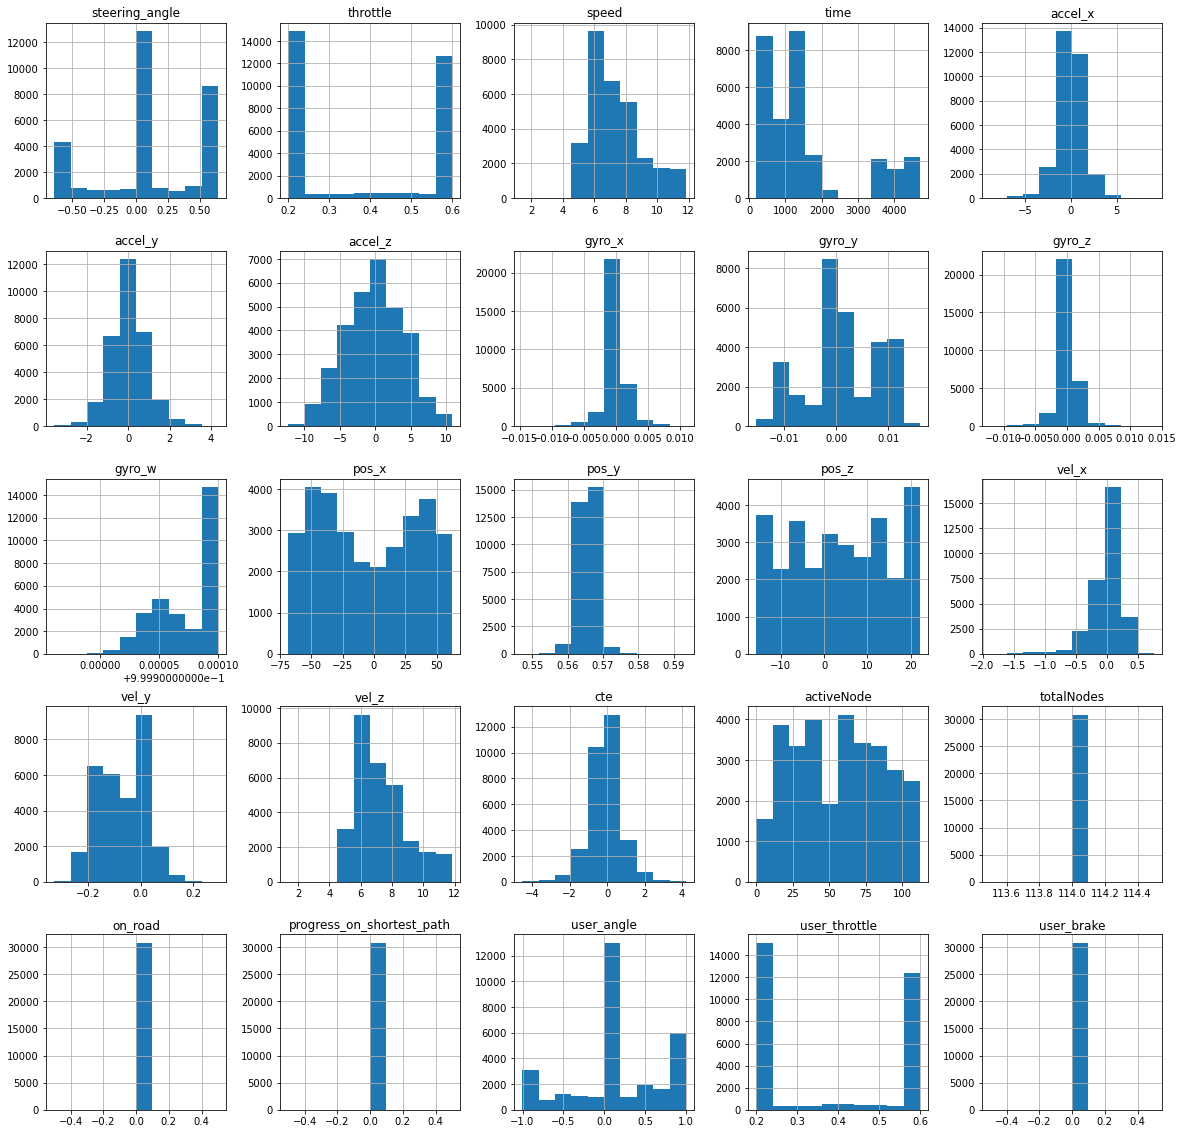

In [10]:
raw_data.hist(figsize=(20,20))

## Préparer la dataset

### Split en 3 jeux : Train, Test et Validation

In [11]:
train_and_test_set, validation_set = train_test_split(raw_data,
                                             test_size = SPLIT_VALIDATION,
                                             shuffle = True)
train_set, test_set = train_test_split(train_and_test_set,
                                             test_size = SPLIT_TEST,
                                             shuffle = True)

NBR_ROW_TRAIN_SET = train_set.shape[0]
NBR_ROW_TEST_SET = test_set.shape[0]
NBR_ROW_VALIDATION_SET = validation_set.shape[0]
print(train_set)
print(test_set)
print(validation_set)

                                                    path  steering_angle  \
9447   corentin_renault_30000_clean_record_controller...        0.000000   
988    corentin_renault_30000_clean_record_controller...        0.172546   
16571  corentin_renault_30000_clean_record_controller...        0.000000   
29039  corentin_renault_30000_clean_record_controller...       -0.294128   
3613   corentin_renault_30000_clean_record_controller...        0.000000   
...                                                  ...             ...   
12902  corentin_renault_30000_clean_record_controller...        0.000000   
30302  corentin_renault_30000_clean_record_controller...       -0.640000   
14     corentin_renault_30000_clean_record_controller...        0.000000   
21185  corentin_renault_30000_clean_record_controller...        0.640000   
30423  corentin_renault_30000_clean_record_controller...        0.640000   

       throttle      speed   hit       time   accel_x   accel_y   accel_z  \
9447   0.6

### Traitements avec TensorData

#### Donkey Car Data Augmentator

In [12]:
class DonkeyCarDataAugmentator:
  @staticmethod
  def normalize(img):
    return (img / 127.5) - 1.0
  
  @staticmethod
  def unnormalize(img):
    return (img + 1.0) * 127.5

  @staticmethod
  def clip_image(img):
    return tf.clip_by_value(img, clip_value_min=0, clip_value_max=255)

  @staticmethod
  def noiser(img, mean, stddev):
    transformed_img = DonkeyCarDataAugmentator.normalize(img)
    noise_img = tf.random.normal(shape=tf.shape(img), mean=mean, stddev=stddev)
    transformed_img = tf.add(transformed_img, noise_img)
    transformed_img = DonkeyCarDataAugmentator.unnormalize(transformed_img)
    transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)
    return transformed_img

  @staticmethod
  def transform(img, angle, ratio_augmentation = 0.75, ratio_flip_left_right = 0.5, max_brightness = 50,
                lower_contrast = 0.75, upper_contrast = 1.5, lower_saturation = 0.0, 
                upper_saturation = 2, mean_noise = 0.0, max_noise = 0.3):
    
    random_do_augmentation = tf.random.uniform(shape=[], minval = 0., maxval = 1., dtype=tf.float32)
    if random_do_augmentation <= ratio_augmentation:
      transformed_img = tf.image.random_brightness(img, max_delta = max_brightness)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)

      transformed_img = tf.image.random_contrast(transformed_img, lower = lower_contrast, upper = upper_contrast)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)
      
      transformed_img = tf.image.random_saturation(transformed_img, lower = lower_saturation, upper = upper_saturation)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)

      random_noise_gain = tf.random.uniform(shape=[], minval = 0.0, maxval = max_noise, dtype=tf.float32)
      transformed_img = DonkeyCarDataAugmentator.noiser(transformed_img, mean_noise, random_noise_gain)
    else:
      transformed_img = img
    
    random_do_flip = tf.random.uniform(shape=[], minval = 0., maxval = 1., dtype=tf.float32)
    if random_do_flip <= ratio_flip_left_right:
      transformed_img = tf.image.flip_left_right(transformed_img)
      angle *= -1
    
    return transformed_img, angle

#### Donkey Car Tensor Builder

In [13]:
class DonkeyCarTensorBuilder:
  def __init__(self, input_label = {'input':['path']}, output_label = {'angle':['user_angle']}, num_parallel_calls = 3, image_shape = (120, 160, 3)):
    self.input_label = input_label
    self.output_label = output_label
    
    self.num_parallel_calls = num_parallel_calls
    self.image_shape = image_shape
  
  def dataset_to_tensor(self, dataset):
    """
    {"input" : dataset['path'], "speed_accel_gyro" : dataset[['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']]}, {"angle" : dataset['angle']}
    :return: Tensor
    """
    input_dict = {}
    output_dict = {}

    # Inputs
    for k, l in self.input_label.items():
      if len(l) != 0:
        if len(l) == 1:
          input_dict[k] = dataset[l[0]]
        else:
          input_dict[k] = dataset[l]

    # Outputs
    for k, l in self.output_label.items():
      if len(l) != 0:
        if len(l) == 1:
          output_dict[k] = dataset[l[0]]
        else:
          output_dict[k] = dataset[l]
    return tf.data.Dataset.from_tensor_slices((input_dict, output_dict))
  
  def load_image(self, dataset_tensor):
    def load_image_map_func(inputs, outputs):
      loaded_inputs = dict(inputs)

      img = tf.io.read_file(inputs['input'])
      img = tf.cast(tf.image.decode_jpeg(img, channels=3), dtype=tf.float32)
      img = tf.reshape(img, self.image_shape)
      loaded_inputs['input'] = img

      return loaded_inputs, outputs
    return dataset_tensor.map(load_image_map_func, num_parallel_calls = self.num_parallel_calls)
  
  def make_augmentation(self, dataset_tensor, ratio_augmentation = 0.5, ratio_flip_left_right = 0.5, max_brightness = 50,
                  lower_contrast = 0.75, upper_contrast = 1.5, lower_saturation = 0.0, 
                  upper_saturation = 2, mean_noise = 0.0, max_noise = 0.3):
    def augmentation_map_func(inputs, outputs):
      transformed_inputs = dict(inputs)
      transformed_outputs = dict(outputs)
      img = inputs['input']
      angle = outputs['angle']

      transformed_img, transformed_angle = DonkeyCarDataAugmentator.transform(img, 
                                                                  angle = angle, 
                                                                  ratio_augmentation = ratio_augmentation, 
                                                                  ratio_flip_left_right = ratio_flip_left_right, 
                                                                  max_brightness = max_brightness,
                                                                  lower_contrast = lower_contrast, 
                                                                  upper_contrast = upper_contrast, 
                                                                  lower_saturation = lower_saturation, 
                                                                  upper_saturation = upper_saturation, 
                                                                  mean_noise = mean_noise, 
                                                                  max_noise = max_noise)

      transformed_img = tf.reshape(transformed_img, self.image_shape)
      transformed_inputs['input'] = transformed_img
      transformed_outputs['angle'] = transformed_angle
      return transformed_inputs, transformed_outputs
    return dataset_tensor.map(augmentation_map_func, num_parallel_calls = self.num_parallel_calls)
  
  def normalize_dataset(self, dataset_tensor):
    def normalize_map_func(inputs, outputs):
      transformed_inputs = dict(inputs)
      transformed_img = inputs['input']
      transformed_img = DonkeyCarDataAugmentator.normalize(transformed_img)
      transformed_img = tf.reshape(transformed_img, self.image_shape)
      transformed_inputs['input'] = transformed_img
      return transformed_inputs, outputs
    return dataset_tensor.map(normalize_map_func, num_parallel_calls = self.num_parallel_calls)


#### Préparer la dataset
Shape des IO, Convertir en Tensor, Preprocess, Augmentation possiblement

In [14]:
### <<< CONFIG >>> ###
input_label = {'input':['path'], 'speed_accel_gyro':['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']}
output_label = {'angle':['user_angle']}

tensor_builder = DonkeyCarTensorBuilder(input_label = input_label,
                                        output_label = output_label,
                                        num_parallel_calls = 3,
                                        image_shape = IMAGE_SHAPE)

# Transforme panda DataFrame en Tensor
train_tensor = tensor_builder.dataset_to_tensor(train_set)
test_tensor = tensor_builder.dataset_to_tensor(train_set)
validation_tensor = tensor_builder.dataset_to_tensor(train_set)

# Charger les images, i.e lire les path et stocker les images à la place
train_tensor = tensor_builder.load_image(train_tensor)
test_tensor = tensor_builder.load_image(test_tensor)
validation_tensor = tensor_builder.load_image(validation_tensor)

# Mélanger, répéter, faire des batch et activer le pré-traitement
# On répète train_tensor pour faire de l'augmentation
train_tensor = train_tensor.shuffle(NBR_ROW_TRAIN_SET)#.repeat(2) ### <<< CONFIG >>> (repeat) ###
test_tensor = test_tensor.shuffle(NBR_ROW_TEST_SET)
validation_tensor = validation_tensor.shuffle(NBR_ROW_VALIDATION_SET)

### <<< CONFIG >>> (comment or not) ###
# Augmentation
"""
train_tensor = tensor_builder.make_augmentation(train_tensor, 
                                                ratio_augmentation = 0.5, 
                                                ratio_flip_left_right = 0.5, 
                                                max_brightness = 50,
                                                lower_contrast = 0.75, 
                                                upper_contrast = 1.5, 
                                                lower_saturation = 0.0, 
                                                upper_saturation = 2, 
                                                mean_noise = 0.0, 
                                                max_noise = 0.3)
"""
# Normaliser les images
train_tensor = tensor_builder.normalize_dataset(train_tensor).batch(BATCH_SIZE).prefetch(2)
test_tensor = tensor_builder.normalize_dataset(test_tensor).batch(BATCH_SIZE).prefetch(2)
validation_tensor = tensor_builder.normalize_dataset(validation_tensor).batch(BATCH_SIZE).prefetch(2)

#### Afficher les images de la dataset
C'est pour voir l'augmentation a bien fonctionné

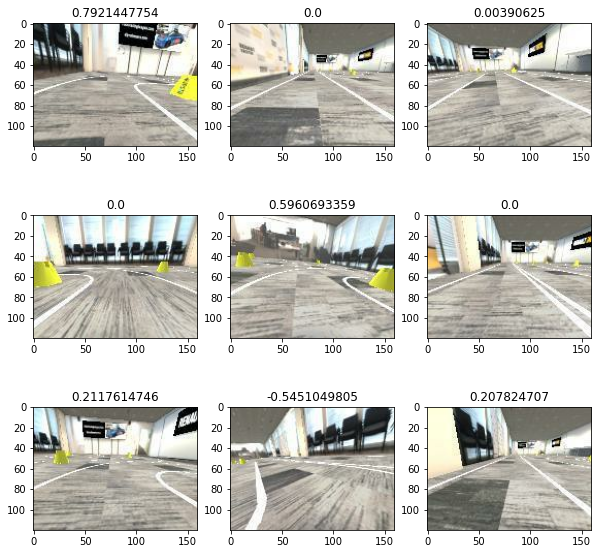

In [15]:
plt.figure(figsize=(10, 10))
for i, o in train_tensor.take(1):
  img = DonkeyCarDataAugmentator.unnormalize(i['input'].numpy())
  for k in range(9):
    ax = plt.subplot(3, 3, k + 1)
    plt.imshow(img[k].astype("uint8"))
    plt.title(str(o['angle'][k].numpy()))

## Définir le modèle

### Définir ModelSaver

In [16]:
class ModelSaver:
  """
  Save the model into a file ('model.code') as source code
  """
  def __init__(self, activate = True):
    """
    Initialize the saver
    :param activate: capture or not the source code of decorated functions
    """
    self.is_activated = activate
    self.s_init = None
    self.s_call = None
  def init(self, funct):
    """
    Capture the source code of the init function
    ---
    Use as a decoration
    Such as :
    ```
    MODEL_SAVER = ModelSaver(True)
    ...
    @MODEL_SAVER.init
    def __init__(self, name = ""):
      ...
    ```
    """
    def funct_with_params(*args, **kwargs):
      return funct(*args, **kwargs)
    if self.is_activated and self.s_init is None:
      self.s_init = inspect.getsource(funct)
    return funct_with_params

  def call(self, funct):
    """
    Capture the source code of the init function
    ---
    Use as a decoration
    Such as :
    ```
        MODEL_SAVER = ModelSaver(True)
        ...
        @MODEL_SAVER.call
        def call(self):
            ...
    ```
    """
    def funct_with_params(*args, **kwargs):
      return funct(*args, **kwargs)
    if self.is_activated and self.s_call is None:
      self.s_call = inspect.getsource(funct)
    return funct_with_params
  
  def save(self, path):
    """
    Save the source code of the model as a file
    :param path: file path
    """
    if self.s_init is not None and self.s_call is not None:
      with open(path, "w") as s:
        s.write("class DCModel(keras.Model):\n")
        s.write("  MODEL_SAVER = ModelSaver(False)\n")
        s.write(self.s_init)
        s.write(self.s_call)
    else:
      raise Exception("init or call function are not saved")
  @staticmethod
  def load(path):
    """
    Load the Model source code
    :param path: file path
    """
    with open(path, "r") as s:
      exec(s.read())

### Création du modèle

In [17]:
LR = 0.00035

In [18]:
MODEL_SAVER = ModelSaver(True)

class DCModel(keras.Model):
  @MODEL_SAVER.init
  def __init__(self, name="DCModel"):
    super(DCModel, self).__init__(name=name)
    #self.input_layer = keras.layers.Input(shape=IMAGE_SHAPE, name='input')
    self.cnn_1 = keras.layers.Conv2D(24, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu', name='input')
    self.bn_1 = tf.keras.layers.BatchNormalization()

    self.cnn_2 = keras.layers.Conv2D(36, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_2 = keras.layers.BatchNormalization()

    self.cnn_3 = keras.layers.Conv2D(48, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_3 = keras.layers.BatchNormalization()

    self.cnn_4 = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_4 = keras.layers.BatchNormalization()

    self.cnn_5 = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_5 = keras.layers.BatchNormalization()

    self.drop_1 = keras.layers.Dropout(0.2)

    self.flat = keras.layers.Flatten()

    self.middle_input = keras.layers.Dense(7, name='speed_accel_gyro')
    self.bn_middle = keras.layers.BatchNormalization()
    self.merge = keras.layers.Concatenate()

    self.dense_1 = keras.layers.Dense(100, kernel_initializer='he_uniform', activation='elu')
    self.bn_6 = keras.layers.BatchNormalization()
    self.drop_2 = keras.layers.Dropout(0.1)

    self.dense_2 = keras.layers.Dense(50, kernel_initializer='he_uniform', activation='elu')
    self.bn_7 = keras.layers.BatchNormalization()
    self.drop_3 = keras.layers.Dropout(0.1)

    self.dense_3 = keras.layers.Dense(25, kernel_initializer='he_uniform', activation='elu')
    self.bn_8 = keras.layers.BatchNormalization()

    self.output_layer_1 = keras.layers.Dense(1, activation='linear', name='angle')
    #self.output_layer_2 = keras.layers.Dense(1, activation='linear', name='throttle')
  
  @MODEL_SAVER.call
  @tf.function
  def call(self, inputs, training=False):
    l = self.cnn_1(inputs['input'])
    l = self.bn_1(l)
    
    l = self.cnn_2(l)
    l = self.bn_2(l)

    l = self.cnn_3(l)
    l = self.bn_3(l)

    l = self.cnn_4(l)
    l = self.bn_4(l)

    l = self.cnn_5(l)
    l = self.bn_5(l)

    l = self.drop_1(l)

    l = self.flat(l)

    m = self.middle_input(inputs['speed_accel_gyro'])
    m = self.bn_middle(m)

    l = self.merge([l, m])

    l = self.dense_1(l)
    l = self.bn_6(l)
    l = self.drop_2(l)

    l = self.dense_2(l)
    l = self.bn_7(l)
    l = self.drop_3(l)

    l = self.dense_3(l)
    l = self.bn_8(l)
    
    return {'angle' : self.output_layer_1(l)}

model = DCModel(name='DonkeyCarModel')

optimizer = keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer,loss=keras.losses.MSE, metrics=["mse"])

## Entraîner le modèle

In [19]:
### <<< CONFIG >>> ###
INITIAL_EPOQUE = 0
NBR_EPOQUES = 100
NBR_EPOQUES_APRES_EARLY_STOPPING = 4
STEPS_PER_EPOCH = int(NBR_ROW_TRAIN_SET / BATCH_SIZE)
NUMBER_EPOCH_CHECKPOINT = 10

### <<< CONFIG >>> ###
"""
keras.callbacks.EarlyStopping(patience=NBR_EPOQUES_APRES_EARLY_STOPPING, restore_best_weights=True)


 keras.callbacks.ModelCheckpoint(filepath=SAVE_PATH,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)
"""
# Définir les callback
cb = [
        keras.callbacks.TensorBoard(log_dir=get_new_tensorlog_path(), histogram_freq=1),
        keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_FILEPATH,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    save_freq= NUMBER_EPOCH_CHECKPOINT * STEPS_PER_EPOCH
                                    )
     ]


In [20]:
# Entraîner le modèle
with tf.device("/gpu:1"):
    model.fit(train_tensor,
              validation_data = test_tensor,
              epochs = NBR_EPOQUES,
              initial_epoch = INITIAL_EPOQUE,
              callbacks=cb)

Epoch 1/100
109/109 [==============================] - 20s 118ms/step - loss: 0.7642 - mse: 0.7642 - val_loss: 0.1602 - val_mse: 0.1602
Epoch 2/100
109/109 [==============================] - 15s 107ms/step - loss: 0.1217 - mse: 0.1217 - val_loss: 0.0830 - val_mse: 0.0830
Epoch 3/100
109/109 [==============================] - 15s 107ms/step - loss: 0.0909 - mse: 0.0909 - val_loss: 0.0528 - val_mse: 0.0528
Epoch 4/100
109/109 [==============================] - 15s 107ms/step - loss: 0.0766 - mse: 0.0766 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 5/100
109/109 [==============================] - 15s 107ms/step - loss: 0.0663 - mse: 0.0663 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 6/100
109/109 [==============================] - 15s 107ms/step - loss: 0.0592 - mse: 0.0592 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 7/100
109/109 [==============================] - 15s 107ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 8/100
109/109 [===========================

Epoch 61/100
109/109 [==============================] - 15s 108ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 62/100
109/109 [==============================] - 16s 108ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 63/100
109/109 [==============================] - 16s 108ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 64/100
109/109 [==============================] - 16s 108ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 65/100
109/109 [==============================] - 16s 110ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 66/100
109/109 [==============================] - 16s 108ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 67/100
109/109 [==============================] - 16s 108ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 68/100
109/109 [===================

## Sauvegarde le modèle

In [ ]:
# Ne fonctionne plus en l'état actuel avec les décorateurs de ModelSaver
# model.save(SAVE_PATH, save_format='tf')

In [21]:
print(SAVE_PATH)

data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247


In [22]:
model.save_weights(os.path.join(SAVE_PATH, "weights.data"))
MODEL_SAVER.save(os.path.join(SAVE_PATH, "model.code"))

In [23]:
print(MODEL_NAME)
print(SAVE_PATH)

DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247
data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247


In [24]:
!tar -czvf $MODEL_NAME_TAR $SAVE_PATH

data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247/
data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247/checkpoints/
data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247/checkpoints/checkpoint-90.weight.index
data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247/checkpoints/checkpoint-10.weight.index
data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247/checkpoints/checkpoint-20.weight.data-00000-of-00001
data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247/checkpoints/checkpoint-100.weight.index
data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247/checkpoints/checkpoint-70.weight.data-00000-of-00001
data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247/checkpoints/checkpoint-40.weight.index
data/model/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247/checkpoints/checkpoint-20.weight.index


In [25]:
model.summary()

Model: "DonkeyCarModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Conv2D)               multiple                  1824      
_________________________________________________________________
batch_normalization (BatchNo multiple                  96        
_________________________________________________________________
conv2d (Conv2D)              multiple                  21636     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  144       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  43248     
_________________________________________________________________
batch_normalization_2 (Batch multiple                  192       
_________________________________________________________________
conv2d_2 (Conv2D)            multiple               

## Évaluer les performances
On n'évalue pas particulièrement bien les performances ici avec ça mais titrons le ainsi !

In [26]:
performances = model.evaluate(validation_tensor, batch_size = BATCH_SIZE)
print(performances)

109/109 [==============================] - 5s 43ms/step - loss: 0.0014 - mse: 0.0014
[0.0014019929803907871, 0.0014019929803907871]


## Analyser l'entraînement et les performances

Transferer log to TensorBord.Dev

In [27]:
print(MODEL_NAME)
print(os.environ["LOG_PATH"])

DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247
data/log/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247/20210506-222520


```
!python3.9 -m tensorboard.main dev upload --logdir LOG_PATH \
  --name MODEL_NAME \
  --description "Donkey Car Train by ESLR Lab (EPITA)" \
  --one_shot
```

In [28]:
!python3.9 -m tensorboard.main dev upload --logdir $LOG_PATH \
  --name $MODEL_NAME \
  --description "Donkey Car Train by ESLR Lab (EPITA)" \
  --one_shot

2021-05-06 22:57:29.669498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Rwy5cOrwQ4m7BbQwkteaIg/

[2021-05-06T22:57:31] Started scanning logdir.
[2021-05-06T22:57:39] Total uploaded: 400 scalars, 5600 tensors (3.2 MB), 1 binary objects (366.0 kB)
[2021-05-06T22:57:39] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/Rwy5cOrwQ4m7BbQwkteaIg/


## Nettoyer l'environnement

In [ ]:
!rm -rf "dataset"
!rm -rf "dataset.eslr"